# APPM 4720 Applied Deep Learning, Spring 2022
## Progress Report 06 - Few-Shot Learning
### Matching Networks for One Shot Learning
### By Sabrina Liu

Examined and implemented the **Few-Shot Learning** algorithm as described in 2016 Google DeepMind paper *Matching Networks for One Shot Learning* in Keras. Trained the model on `omniglot` dataset and achived some preliminary results.  

#### References:
* Paper: Vinyals, et.al., *Matching Networks for One Shot Learning*, https://arxiv.org/pdf/1606.04080
* Dataset: https://www.kaggle.com/datasets/watesoyan/omniglot
* Tutorial: https://github.com/AntreasAntoniou/MatchingNetworks

The above tutorial implemented the framework in tensorflow v1. This report re-implemented the algorithm in Keras API. 

---
## Set Up Environment

#### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/ADL/FewShot'
!dir

/content/drive/MyDrive/ADL/FewShot
data  images  models


In [3]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Apr 13 01:09:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## Architecture Review

One limitation of traditional supervised deep learning methods used for classification is that it doesn't work on new classes that was unknown in the training. The concept of few-shot learning treats the classification task as a clustering problem, and it requires a support set that includes the class of the classification target, e.g. an image to classifiy. 

#### Matching Nets

The solution is named **Matching Nets** based on a simple principle: train and test conditions must match. During training, only a few examples are shown per class. The architecture is unchanged at test time, and the neural network is able to produce classification labels with only a few examples for each class (support set). The number of classes available in the support set is the *way* (below referenced as 'k-way'), and the number of examples present in each class is the *shot* (below refereneced as 'k-shot'). 

#### Attention Kernel

The prediction of a class label is modeled as a **weighted sum** of all the avalaible labels in the support set in their one-hot form. 
$$ \hat{y} = \sum_{i=1}^k a(\hat{x}, x_i) y_i $$
The weight $a$ is cosine similarity between the image embeddings (of the target image and the support set images) normalized by softmax function:
$$ a = \frac{e^{c(f(\hat{x}), g(x_i))}}{\sum_{j=1}^k e^{c(f(\hat{x}), g(x_j))}}  $$
The weighted sum can be treated as a attention mechanism. Since higher cosine similarity score correspond to closer distance in the vector space, the classification method is analogous to a **weighted nearest neighour clustering** algorithm.  

#### Full Context Embeddings

The main novelty of this architecture is the usage of LSTM layers to encode the inter-class context information of image embeddings from a CNN feature extractor like the Inception model. The support set $S$ is first passed into the CNN, then passed into a bidirectional LSTM mechanism $g$ to produce image embeddings. So each element of the support set $x_i$ is embedded as $g(x_i, S)$. To obtain the similarity of the target image $\hat{x}$ (to be classified) to the support set, the target image is first passed through the CNN which results in feature map $f^\prime$, then passed into attention LSTM mechanism (first LSTM layer, then attention is calculated with support set embeddings $g$) with $K$ rolling steps. 

$$ f(\hat{x},S) = \text{attLSTM}(f^\prime(\hat{x}), g(S), K) $$

#### Similarity Score and Classification

The final classification decision is made based on the cosine similarity score between image embeddings produced from above layers, applied with softmax and producing the most likely label from the given classes. The final loss calculated is categorical cross-entropy loss between softmax logits and true one-hot labels. 

---
## The Omniglot Dataset

As shown below from the tensorflow built-in dataset information, the dataset contains a total of 50 different languages, including 1623 different characters (classes) , and each character comes with 20 examples in grayscale images of resolution (105, 105). See detailed preview below. 

* https://www.kaggle.com/datasets/watesoyan/omniglot
* https://www.tensorflow.org/datasets/catalog/omniglot
* https://github.com/brendenlake/omniglot/

In [6]:
import tensorflow_datasets as tfds

_, info = tfds.load('omniglot', with_info=True, shuffle_files=False)
info

tfds.core.DatasetInfo(
    name='omniglot',
    version=3.0.0,
    description='Omniglot data set for one-shot learning. This dataset contains 1623 different
handwritten characters from 50 different alphabets.',
    homepage='https://github.com/brendenlake/omniglot/',
    features=FeaturesDict({
        'alphabet': ClassLabel(shape=(), dtype=tf.int64, num_classes=50),
        'alphabet_char_id': tf.int64,
        'image': Image(shape=(105, 105, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1623),
    }),
    total_num_examples=38300,
    splits={
        'small1': 2720,
        'small2': 3120,
        'test': 13180,
        'train': 19280,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lake2015human,
      title={Human-level concept learning through probabilistic program induction},
      author={Lake, Brenden M and Salakhutdinov, Ruslan and Tenenbaum, Joshua B},
      journal={Science},
      volume={350},
      number=

#### Preview the Images

Below lists out the train-validation split of language types. The training set includes 30 languages, 964 characters, 19280 data points. The validation set includes 20 languages, 659 characters, 13180 data points. The classes in the validation set are not present in the training set since they are distinctly different languages. In below preview, 3 languages are chosen from the training set, with 15 characters from each language, and 3 examples from each character for display. 

In [7]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dataset = 'omniglot'
train_dir = f'./data/{dataset}/train'
valid_dir = f'./data/{dataset}/valid'

print('Languages for Training:', len(os.listdir(train_dir)))
print('-' * 50)
sorted(os.listdir(train_dir))

Languages for Training: 30
--------------------------------------------------


['Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh']

In [9]:
print('Languages for Testing:')
print('-' * 50)
sorted(os.listdir(valid_dir))

Languages for Testing:
--------------------------------------------------


['Angelic',
 'Atemayar_Qelisayer',
 'Atlantean',
 'Aurek-Besh',
 'Avesta',
 'Ge_ez',
 'Glagolitic',
 'Gurmukhi',
 'Kannada',
 'Keble',
 'Malayalam',
 'Manipuri',
 'Mongolian',
 'Old_Church_Slavonic_(Cyrillic)',
 'Oriya',
 'Sylheti',
 'Syriac_(Serto)',
 'Tengwar',
 'Tibetan',
 'ULOG']

CPU times: user 2.38 s, sys: 104 ms, total: 2.48 s
Wall time: 2.57 s


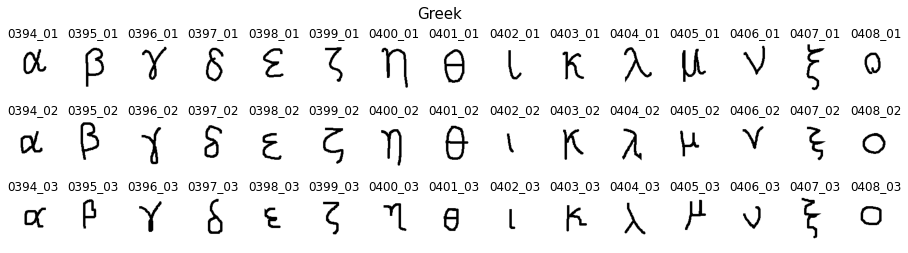

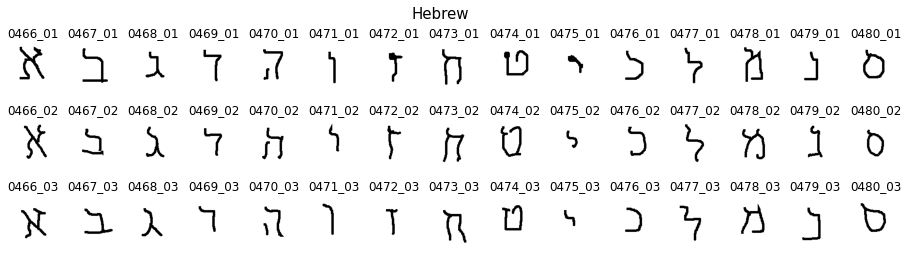

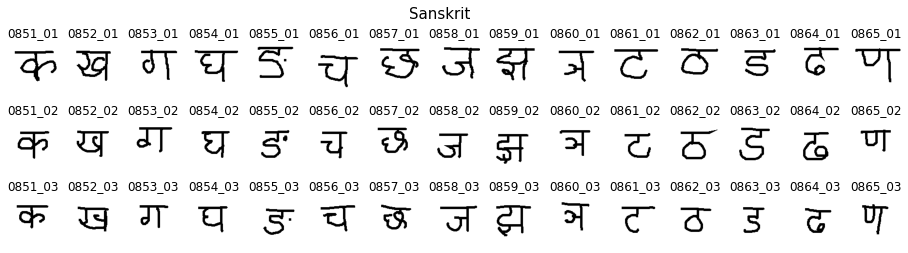

In [10]:
%%time

N_CLASSES = 15
N_SAMPLES = 3

def show_examples(lang):
    fig, axes = plt.subplots(N_SAMPLES, N_CLASSES, figsize=(N_CLASSES+1, N_SAMPLES+1))
    fig.suptitle(lang.title(), fontsize=15)
    lang_dir = os.path.join(train_dir, lang)
    for i, char in enumerate(sorted(os.listdir(lang_dir))[:N_CLASSES]):
        char_dir = os.path.join(lang_dir, char)
        for j, sample in enumerate(sorted(os.listdir(char_dir))[:N_SAMPLES]):
            img = np.array(Image.open(os.path.join(char_dir, sample)))
            axes[j, i].set(title=sample.replace('.png', ''))
            axes[j, i].imshow(img, cmap='gray')
            axes[j, i].axis('off')

for lang in ['Greek', 'Hebrew', 'Sanskrit']:
    show_examples(lang)

#### Load the Images into Arrays

The source data are available in embedded directories. Below scripts copy all the classes into the same level directory for tensorflow to load. This only needs to be run once. 

In [11]:
import shutil

In [12]:
%%time

train_dir_all = train_dir + '_all'
valid_dir_all = valid_dir + '_all'

def combine_classes(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
        for lang in os.listdir(source_dir):
            lang_dir = os.path.join(source_dir, lang)
            for char in os.listdir(lang_dir):
                char_dir = os.path.join(lang_dir, char)
                class_name = f"{lang}_{char}"
                new_dir = os.path.join(target_dir, class_name)
                try:
                    shutil.copytree(char_dir, new_dir)
                except Exception:
                    pass

combine_classes(train_dir, train_dir_all)
combine_classes(valid_dir, valid_dir_all)

CPU times: user 0 ns, sys: 136 µs, total: 136 µs
Wall time: 838 µs


In [13]:
IMAGE_SIZE = (105, 105)
BATCH_SIZE = 64

In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from functools import partial

In [15]:
%%time

load_data = partial(
    image_dataset_from_directory,
    labels='inferred',
    image_size=IMAGE_SIZE,
    batch_size=None,             # do not create batches
    validation_split=None,       # do not split
    color_mode='grayscale',
    label_mode='int',
    shuffle=True,
    crop_to_aspect_ratio=True,   # do not distort image
)

ds_train = load_data(directory=train_dir_all)
ds_valid = load_data(directory=valid_dir_all)

Found 19280 files belonging to 964 classes.
Found 13180 files belonging to 659 classes.
CPU times: user 3.2 s, sys: 1.6 s, total: 4.8 s
Wall time: 3.32 s


In [16]:
len(ds_train)

19280

---
## Preprocessing

#### Image Scaling

For both training and testing, we scale the image data from [0, 255] to [0, 1].  

In [17]:
for x, y in ds_train.take(1):
    print(x.shape, y.numpy(), tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())

(105, 105, 1) 359 0.0 255.0


In [18]:
def scale_image(image, label):              # [0, 255] => [0, 1]
    return image / 255., label

ds_train_scale = ds_train.map(scale_image)
ds_valid_scale = ds_valid.map(scale_image)

for x, y in ds_train_scale.take(1):
    print(x.shape, y.numpy(), tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())

(105, 105, 1) 831 0.0 1.0


#### Get Target Images and Labels

For data engineering, we convert the target images and labels into numpy and save it locally for later use. 

In [19]:
%%time

import pickle

def get_numpy(dataset, split):
    pickle_dir = f'./data/omniglot/numpy'
    if not os.path.exists(pickle_dir):
        os.mkdir(pickle_dir)
    pickle_file = os.path.join(pickle_dir, f'{split}.pkl')
    if os.path.exists(pickle_file):
        print("Loading pickle file ...")
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
    else:
        data = list(dataset.as_numpy_iterator())
        print("Saving pickle file ...")
        with open(pickle_file, 'wb') as f:
            pickle.dump(data, f)
    return data

ds_train_numpy = get_numpy(ds_train_scale, 'train')
ds_valid_numpy = get_numpy(ds_valid_scale, 'valid')

print(len(ds_train_numpy), len(ds_valid_numpy))

Loading pickle file ...
Loading pickle file ...
19280 13180
CPU times: user 361 ms, sys: 1.33 s, total: 1.7 s
Wall time: 1.78 s


In [20]:
xt_train = [x for x, _ in ds_train_numpy]
yt_train = [y for _, y in ds_train_numpy]

xt_valid = [x for x, _ in ds_valid_numpy]
yt_valid = [y for _, y in ds_valid_numpy]

len(xt_train), len(yt_train), len(xt_valid), len(yt_valid)

(19280, 19280, 13180, 13180)

#### Get Support Images and Labels

Below process creates the corresponding k-way k-shot support set as part of the training data. The support set needs to include the class that the target image belongs to and k-way - 1 different classes. By default, we will use 5-way support sets with 1 to 5 shots. 

In [21]:
%time

def create_support_set(xt, yt, target_label, k_way=5, k_shot=1):   

    sample_labels = [target_label]
    # populate k-way labels
    while len(sample_labels) < k_way:
        next_label = np.random.randint(len(set(yt)))    # train: 964, valid: 659
        if next_label not in sample_labels:
            sample_labels.append(next_label)    

    xt = np.array(xt)
    yt = np.array(yt)

    support_images, support_labels = [], []
    for label in sample_labels:
        indices = np.random.choice(np.where(yt==label)[0], size=k_shot)
        support_images.extend(xt[indices])
        support_labels.extend(yt[indices])

    return np.array(support_images), np.array(support_labels)

x, y = create_support_set(xt_train, yt_train, target_label=1)
x.shape, y

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs


((5, 105, 105, 1), array([  1, 218,  74, 382, 146], dtype=int32))

In [22]:
%%time

from tqdm import trange

def create_training_data(xt, yt, k_way=5, k_shot=1, n_records=None):

    model_name = f"{k_way}_way_{k_shot}_shot"
    data_file = f"./data/omniglot/numpy/{model_name}.pkl"
    xs, ys = [], []

    if os.path.exists(data_file):
        pass
    else:
        if not n_records:
            n_records = len(yt)

        for i in trange(n_records):
            label = yt[i]
            x, y = create_support_set(xt, yt, label, k_way, k_shot)
            xs.append(x)
            ys.append(y)

        data = dict(xt=xt, yt=yt, xs=xs, ys=ys)
        print(f"saving data for {model_name} to {data_file} ...")
        with open(data_file, 'wb') as f:
            pickle.dump(data, f)

    return xs, ys

for k_way in [5]:
    for k_shot in [1, 2, 3, 4, 5]:
        xs_train, ys_train = create_training_data(xt_train, yt_train, k_way, k_shot)
        print(len(xs_train), len(ys_train))

0 0
0 0
0 0
0 0
0 0
CPU times: user 3.61 ms, sys: 527 µs, total: 4.14 ms
Wall time: 3.03 ms


---
## Model Implementation

Both the target image and the support set images first go through a CNN feature extractor. For training simplicity we use a very small CNN to perform this task. In real production, we might want to use something like ResNet or Inception model. The `gLSTM` and `fLSTM` modules respectively implemented the $g$ and $f$ functions as described in the paper to produce *Full-Context Embedding*. Customized training and prediction steps are built to implement the model. 

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Attention

In [24]:
def FeatureExtractor(input_shape=(105, 105, 1), summary=False):
    """
    produce image embeddings as feature extractions with CNN
    output shape: (B, 64)
    """
    x = Input(shape=input_shape, name='input')
    z = x

    n_filters = [64, 64, 64, 64, 64, 64]

    for i, n in enumerate(n_filters):
        z = Conv2D(filters=n, kernel_size=2, strides=1, padding='valid', name=f"conv_{i+1}")(z)
        z = BatchNormalization(name=f"conv_bn_{i+1}")(z)
        z = LeakyReLU(alpha=.2, name=f"conv_leakyrelu_{i+1}")(z)
        z = MaxPooling2D(pool_size=(2,2), strides=2, padding='same', name=f"maxpool_{i+1}")(z)

    z = Flatten(name='flatten')(z)
    model = Model(inputs=x, outputs=z, name='FeatureExtractor')
    
    if summary:
        display(model.summary(positions=[.5, .9, 1]))
    
    return model

_ = FeatureExtractor(summary=True)

Model: "FeatureExtractor"
_________________________________________________________________
 Layer (type)                   Output Shape              Param #
 input (InputLayer)             [(None, 105, 105, 1)]     0      
                                                                 
 conv_1 (Conv2D)                (None, 104, 104, 64)      320    
                                                                 
 conv_bn_1 (BatchNormalization)  (None, 104, 104, 64)     256    
                                                                 
 conv_leakyrelu_1 (LeakyReLU)   (None, 104, 104, 64)      0      
                                                                 
 maxpool_1 (MaxPooling2D)       (None, 52, 52, 64)        0      
                                                                 
 conv_2 (Conv2D)                (None, 51, 51, 64)        16448  
                                                                 
 conv_bn_2 (BatchNormalization)  (None, 51, 51, 64

None

In [25]:
def gLSTM(n_samples=10, embedding_dim=64, summary=False):
    """
    output shape: (B, K, 64)
    """
    x = Input(shape=(n_samples, embedding_dim), name='input')
    z = Bidirectional(LSTM(units=64, return_sequences=True), merge_mode='sum', name='bi_lstm')(x)
    z = Add(name='add')([x, z])

    model = Model(inputs=x, outputs=z, name='gLSTM')
    
    if summary:
        display(model.summary(positions=[.35, .63, .72, 1]))
    
    return model

_ = gLSTM(summary=True)

Model: "gLSTM"
__________________________________________________________________________________________________
 Layer (type)                     Output Shape               Param #  Connected to                
 input (InputLayer)               [(None, 10, 64)]           0        []                          
                                                                                                  
 bi_lstm (Bidirectional)          (None, 10, 64)             66048    ['input[0][0]']             
                                                                                                  
 add (Add)                        (None, 10, 64)             0        ['input[0][0]',             
                                                                       'bi_lstm[0][0]']           
                                                                                                  
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
________________________

None

In [26]:
def fLSTM(n_samples=10, k_step=2, embedding_dim=64, summary=False):
    """
    output shape: (B, 1, 64)
    """
    f = Input(shape=(1, embedding_dim), name='f')
    g = Input(shape=(n_samples, embedding_dim), name='g')

    lstm = LSTM(units=64, return_sequences=True, name=f'lstm_1')

    z = f
    for i in range(k_step):
        x = lstm(z)
        z = Add(name=f'add_{i+1}')([z, x])
        z = Attention(name=f'attn_{i+1}')([z, g])

    x = LSTM(units=64, return_sequences=True, name=f'lstm_2')(z)
    z = Add(name=f'add_{i+2}')([z, x])

    model = Model(inputs=[f, g], outputs=z, name='fLSTM')
    
    if summary:
        display(model.summary(positions=[.35, .63, .72, 1]))
    
    return model

_ = fLSTM(summary=True)

Model: "fLSTM"
__________________________________________________________________________________________________
 Layer (type)                     Output Shape               Param #  Connected to                
 f (InputLayer)                   [(None, 1, 64)]            0        []                          
                                                                                                  
 lstm_1 (LSTM)                    (None, 1, 64)              33024    ['f[0][0]',                 
                                                                       'attn_1[0][0]']            
                                                                                                  
 add_1 (Add)                      (None, 1, 64)              0        ['f[0][0]',                 
                                                                       'lstm_1[0][0]']            
                                                                                              

None

In [27]:
import tensorflow as tf
cosine_score = tf.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.NONE)
cross_entropy = tf.keras.losses.CategoricalCrossentropy(name='loss')

from tensorflow.keras.optimizers import Adam

In [28]:
class MatchNet(tf.keras.Model):
    def __init__(self, k_way=5, k_shot=1):
        super().__init__()
        self.k_way=k_way
        self.k_shot=k_shot
        self.n_samples=k_way * k_shot
        self.cnn=FeatureExtractor()
        self.g_lstm=gLSTM(n_samples=self.n_samples)
        self.f_lstm=fLSTM(n_samples=self.n_samples)
        self.n_class=1000

    def compile(self):
        super().compile(optimizer=Adam(0.0001))

    @tf.function
    def train_step(self, data):

        target_image, target_label, support_image, support_label = data
        target_label = tf.one_hot(tf.cast(target_label, tf.int32), self.n_class)
        support_label = tf.one_hot(tf.cast(support_label, tf.int32), self.n_class)
        support_image = tf.reshape(support_image, (-1, 105, 105, 1))             # => (BK, 105, 105, 1)

        # target image:  (B, 105, 105, 1)
        # target label:  (B, N)
        # support image: (B, K, 105, 105, 1)
        # support label: (B, K, N)

        with tf.GradientTape() as tape:

            g_vec = self.cnn(support_image, training=True)                       # => (BK, 64)
            g_vec = tf.reshape(g_vec, (-1, self.n_samples, 64))                  # => (B, K, 64)
            g_vec = self.g_lstm(g_vec, training=True)                            # => (B, K, 64)

            f_vec = self.cnn(target_image, training=True)                        # => (B, 64)
            f_vec = tf.expand_dims(f_vec, axis=1)                                # => (B, 1, 64)
            f_vec = self.f_lstm([f_vec, g_vec], training=True)

            dist = cosine_score(f_vec, g_vec)                                    # => (B, K)
            dist = tf.expand_dims(dist, axis=1)                                  # => (B, 1, K)
            pred = tf.matmul(dist, support_label)                                # => (B, 1, N)
            pred = tf.nn.softmax(tf.squeeze(pred, axis=1))                       # => (B, N)

            loss = cross_entropy(target_label, pred)
            vars = self.cnn.trainable_variables \
                 + self.g_lstm.trainable_variables \
                 + self.f_lstm.trainable_variables
            grad = tape.gradient(loss, vars)
            self.optimizer.apply_gradients(zip(grad, vars))

        results = {m.name: m.result() for m in self.metrics}
        results.update(dict(loss=loss))

        return results

    def __call__(self, data, training=True):

        target_image, (support_image, support_label) = data
        support_label = tf.one_hot(tf.cast(support_label, tf.int32), self.n_class)
        support_image = tf.reshape(support_image, (-1, 105, 105, 1))

        g_vec = self.cnn(support_image, training=False)                      # => (BK, 64)
        g_vec = tf.reshape(g_vec, (-1, self.n_samples, 64))                  # => (B, K, 64)
        g_vec = self.g_lstm(g_vec, training=False)                           # => (B, K, 64)

        f_vec = self.cnn(target_image, training=False)                       # => (B, 64)
        f_vec = tf.expand_dims(f_vec, axis=1)                                # => (B, 1, 64)
        f_vec = self.f_lstm([f_vec, g_vec], training=False)

        dist = cosine_score(f_vec, g_vec)                                    # => (B, K)
        dist = tf.expand_dims(dist, axis=1)                                  # => (B, 1, K)
        pred = tf.matmul(dist, support_label)                                # => (B, 1, N)
        pred = tf.nn.softmax(tf.squeeze(pred, axis=1))                       # => (B, N)

        return tf.argmax(pred, axis=-1)                                      # => (B, )

---
## Training

The training process is set to run 10 epochs each time, with the weights and training performance saved and loaded for later use.

In [29]:
N_EPOCHS = 10
N_WORKERS = 100

fit_dict = dict(
    shuffle=True,
    batch_size=BATCH_SIZE, 
    epochs=N_EPOCHS, 
    verbose=1,
    workers=N_WORKERS, 
    use_multiprocessing=True
)

In [30]:
def get_data(model_name):

    data_file = f"./data/omniglot/numpy/{model_name}.pkl"
    
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    
    data = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(np.array(data['xt'])), 
        tf.data.Dataset.from_tensor_slices(np.array(data['yt'])), 
        tf.data.Dataset.from_tensor_slices(np.array(data['xs'])), 
        tf.data.Dataset.from_tensor_slices(np.array(data['ys'])), 
    )).batch(BATCH_SIZE)
    
    return data

In [31]:
def train_model(k_way, k_shot):

    model = MatchNet(k_way=k_way, k_shot=k_shot)
    model.compile()
    model_name = f"{k_way}_way_{k_shot}_shot"
    model_file = f"./models/{model_name}.tf"
    hist_file = f"./models/{model_name}_history.pkl"
    print(f"Loading data for {model_name} ...")
    data = get_data(model_name)

    if not os.path.exists('./models'):
        os.mkdir('./models')

    current_epoch = 0
    # load pre-trained model and history if available
    if os.path.exists(f"{model_file}.index") and os.path.exists(hist_file):
        print(f"\nLoading model weights for {model_name}...")
        model.load_weights(model_file)
        print(f"\nLoading model history for {model_name}...")
        with open(hist_file, 'rb') as f:
            model_history = pickle.load(f)

        current_epoch = len(model_history['loss'])

    print(f"\nTraining model {model_name}...")
    history = model.fit(data, **fit_dict)

    if current_epoch != 0:
        for key, value in zip(model_history.keys(), history.history.values()):
            model_history[key].extend(value)
    else:
        model_history = history.history

    print(f"\nSaving model history for {model_name}...")
    with open(hist_file, 'wb') as f:
        pickle.dump(model_history, f)

    current_epoch += N_EPOCHS
    print(f"\nSaving model weights for {model_name} epoch {current_epoch}...")
    model.save_weights(model_file)

    return model, model_history

In [32]:
model, model_history = train_model(k_way=5, k_shot=1)

Loading data for 5_way_1_shot ...

Loading model weights for 5_way_1_shot...

Loading model history for 5_way_1_shot...

Training model 5_way_1_shot...
Epoch 1/10
302/302 [==============================] - 39s 95ms/step - loss: 5.9110
Epoch 2/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9106
Epoch 3/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9103
Epoch 4/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9100
Epoch 5/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9097
Epoch 6/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9094
Epoch 7/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9091
Epoch 8/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9089
Epoch 9/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9086
Epoch 10/10
302/302 [==============================] - 28s 93ms/step - loss: 5.9084

Saving model his

#### Training Performance

Due to time limit, I was not able to train 1 to 5 shot as planned. Below is training performance for the 5-way 1-shot model. 

Text(0.5, 1.0, 'Training Loss')

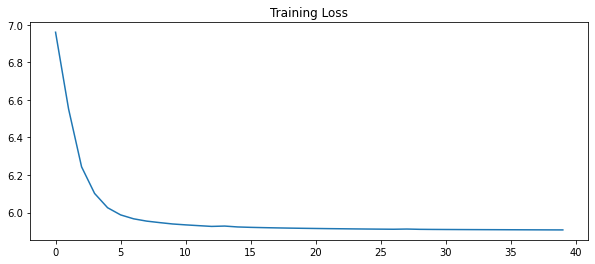

In [33]:
plt.figure(figsize=(10, 4))

_ = plt.plot(model_history['loss'])
plt.title('Training Loss')

---
## Evaluation

To test the performance at inference time, we select 100 random samples from the validation set which have completely different classes from the training set. Therefore the class labels are re-indexed and their one-hot vectors does not have any relationship to the training labels. Each prediction is made with 1 target image, and 5 support set images (1 image from each class). The model allows 1000 different class labels and makes a choice among the 5 available classes. 

In [34]:
def get_test_data(sample_id):
    xt = xt_valid[sample_id]
    yt = yt_valid[sample_id]
    xs, ys = create_support_set(xt_valid, yt_valid, target_label=yt)

    data = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(np.array([xt])), 
        tf.data.Dataset.from_tensor_slices(np.array([yt])), 
        tf.data.Dataset.from_tensor_slices(np.array([xs])), 
        tf.data.Dataset.from_tensor_slices(np.array([ys])), 
    )).batch(1)
    return data

def predict_one(sample_id, print_labels=False):
    data = get_test_data(sample_id)
    for xt, yt, xs, ys in data.take(1):
        true = yt.numpy()
        data = (xt, (xs, ys))
        pred = model.predict(data)
    if print_labels:
        print("true label: ", true)
        print("pred label: ", pred)
    return true[0], pred[0]

_ = predict_one(1, print_labels=True)

true label:  [468]
pred label:  [468]


In [35]:
results = []
for i in trange(100):
    results.append(predict_one(i))

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


In [36]:
y_true = [t for t, _ in results]
y_pred = [p for _, p in results]

score = tf.keras.metrics.Accuracy()
score(y_true, y_pred).numpy()

1.0

The scope of the test was relatively small but looks like the framework does produce some meaningful results for classifying character images with the presence of small support sets with one-shot learning. 